In [1]:
import graph_tool.collection 
import graph_tool.search 
import graph_tool as gt
import random
import numpy as np
import zstandard
import networkx as nx
import copy
import osmnx as ox

import random
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import subprocess
import ast
import datetime
import time

import gurobipy as gp
from gurobipy import GRB
import igraph as ig

In [2]:
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import utils as ut

In [3]:
place = 'Essaouira, Morocco'
g = ut.get_nx_from_ox(place)
wgt = 'length'

G = ox.graph_from_place(place, network_type='drive')

In [4]:
st_pairs = 30 #number of source, target pairs

In [5]:
seed = 7
st = ut.sample_st(g,st_pairs, seed = seed)

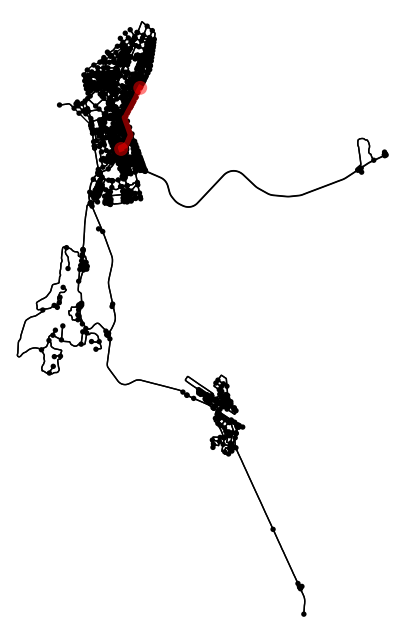

In [6]:
orig_node,dest_node = st[0][0],st[1][0]
route = nx.shortest_path(g, orig_node, dest_node, weight='length',method='dijkstra')
fig, ax = ox.plot_graph_route(G, route, bgcolor='white', edge_color='black', node_color='black')

In [7]:

def convert_to_nxDiGraph(g, s, t):
    name_s, name_t = g.vs[s]['name'], g.vs[t]['name']
    G = nx.DiGraph()
    G.add_weighted_edges_from([
        (g.vs[edge.source]['name'], 
         g.vs[edge.target]['name'], 
         edge['weight'])
        for edge in g.es
    ])
    return G, name_s, name_t


def convert_to_igraph(G, s, t):
    # Create edge list with weights
    edges_with_weights = [(u, v, data.get('weight', 1.0))
                         for u, v, data in G.edges(data=True)]

    # Create graph from weighted edges
    G_prime = ig.Graph.TupleList(edges_with_weights, directed=True,
                                edge_attrs=['weight'])

    # Find new indices for s and t
    for (i, u) in enumerate(G_prime.vs):
        if u['name'] == s: new_s = i
        if u['name'] == t: new_t = i

    assert G_prime.vs[new_s]['name'] == s
    assert G_prime.vs[new_t]['name'] == t
    return G_prime, new_s, new_t        


def lorenz_simultaneous_opt_k(dag, k, s, t):
    n = len(dag.vs)
    model = gp.Model()

    # Add variables: thresholded U, thresholded satisfaction probabilities, and flow (one per edge)
    U = model.addVar(lb=0, ub=1)
    thres_p = model.addVars(dag.vs, lb=0)
    f = model.addVars(dag.es, lb=0)
    model.update()

    # Constraints: thresholded satisfaction <= min(U, satisfaction probability)
    for v in dag.vs:
        model.addConstr(thres_p[v] <= U)
        if v != dag.vs[t]:
            model.addConstr(thres_p[v] <= gp.quicksum(f[e] for e in v.out_edges()))

    # Constraints: prob visiting source and target
    model.addConstr( gp.quicksum(f[e] for e in dag.vs[s].out_edges()) == 1 )
    model.addConstr( gp.quicksum(f[e] for e in dag.vs[t].in_edges()) == 1 )

    # Constraints: out flow = in flow for every v != s, t
    flow_cons = model.addConstrs( ( gp.quicksum(f[e] for e in v.out_edges()) == gp.quicksum(f[e] for e in v.in_edges()) ) for v in dag.vs if v != dag.vs[s] and v != dag.vs[t] )

    model.update()

    # Objective function
    model.setObjective(gp.quicksum(thres_p[v] for v in dag.vs) - (n - k) * U, GRB.MAXIMIZE)

    # Optimize the model
    model.optimize()
    return model, f, flow_cons

def lorenz_simultaneous_opt(dag, s, t):
    alphas = []
    for k in range(1, len(dag.vs) + 1):
        model, f, _ = lorenz_simultaneous_opt_k(dag, k, s, t)
        alphas.append(model.ObjVal)
    return alphas

def simultaneous_gamma_opt(dag, s, t):
    alpha = lorenz_simultaneous_opt(dag, s, t)

    n = len(dag.vs)
    model = gp.Model()

    # Add variables
    gamma = model.addVar(lb=0, ub=1)
    U = [ model.addVar(lb=0, ub=1) for i in range(n) ]
    thres_p = [ model.addVars(dag.vs, lb=0) for i in range(n) ]
    f = model.addVars(dag.es, lb=0)
    model.update()

    # Constraints: thresholded satisfaction <= min(U, satisfaction probability)
    for k in range(n):
        for v in dag.vs:
            model.addConstr(thres_p[k][v] <= U[k])
            if v != dag.vs[t]:
                model.addConstr(thres_p[k][v] <= gp.quicksum(f[e] for e in v.out_edges()))
        model.addConstr(gp.quicksum(thres_p[k][v] for v in dag.vs) - (n - (k + 1)) * U[k] >= gamma * alpha[k])

    # Constraints: prob visiting source and target
    model.addConstr( gp.quicksum(f[e] for e in dag.vs[s].out_edges()) == 1 )
    model.addConstr( gp.quicksum(f[e] for e in dag.vs[t].in_edges()) == 1 )

    # Constraints: out flow = in flow for every v != s, t
    flow_cons = model.addConstrs( ( gp.quicksum(f[e] for e in v.out_edges()) == gp.quicksum(f[e] for e in v.in_edges()) ) for v in dag.vs if v != dag.vs[s] and v != dag.vs[t] )

    model.update()

    # Objective function
    model.setObjective(gamma, GRB.MAXIMIZE)

    # Optimize the model
    model.optimize()

    result = {
        'flow': { (dag_prime.vs[e.source]['name'], dag_prime.vs[e.target]['name']):var.x for (e, var) in f.items() }
    }
    return model, model.objVal, alpha, f, result

def analyze_simult_solution(dag, model, all_vars, s, t):
    gamma = model.objVal
    f = all_vars

    # Add the flow to the DAG as probabilities and compute also conditional probabilities
    for v in dag.vs:
        # Calculate total outgoing flow for each vertex
        total_out_flow = sum(f[e].X for e in v.out_edges())
        v['prob'] = total_out_flow

        for e in v.out_edges():
            flow_value = f[e].X  # Get the optimal flow value for this edge
            e['prob'] = flow_value  # Add 'prob' attribute to the edge

            # Calculate and add conditional probability
            if total_out_flow > 0:
                e['cond_prob'] = flow_value / total_out_flow
            else:
                e['cond_prob'] = 0
    dag.vs[t]['prob'] = 1

    # Compute the expected number of vertices visited in a path (including s and t)
    exp_numv = 1 + np.array(dag.es['prob']).sum()
    return {"gamma":gamma, "exp_numv":exp_numv}, {u['name']:u['prob'] for u in dag_prime.vs}



if __name__ == "__main__":
    #nx_dag = create_dag_with_10_nodes()
    dag = ut.get_dag(g, orig_node, dest_node, weight=wgt)

    dag_prime, s_prime, t_prime = convert_to_igraph(dag, s=orig_node, t=dest_node)

    model, gamma, sim_alpha, f, result = simultaneous_gamma_opt(dag_prime, s_prime, t_prime)   # new reference  

    
    print('done')        # the new reference; the first element (index 0) means bottom k=1; the last is bottom k=n (all nodes)





Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xbe0614ac
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.01s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   3.508000e+00   0.000000e+00      0s
      47    1.2500000e-01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.250000000e-01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5

       0    9.0160000e+00   1.854000e+01   0.000000e+00      0s
      91    1.2857143e+00   0.000000e+00   0.000000e+00      0s

Solved in 91 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.285714286e+00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0x767f4705
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0018000e+01   1.954400e+01   0.000000e+00      0s
      82    1.4285714e+00   0.000000e+00   0.000000e+00      0s

Solved in 82 iterations and 0.01 sec

Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8032000e+01   3.357200e+01   0.000000e+00      0s
     128    2.7142857e+00   0.000000e+00   0.000000e+00      0s

Solved in 128 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.714285714e+00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xdbd69389
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9034000e+01   3.5

  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7048000e+01   4.810300e+01   0.000000e+00      0s
     135    4.6000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 135 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.600000000e+00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xb86d924e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s


Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0x0a1d16d4
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.01s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7068000e+01   6.714100e+01   0.000000e+00      0s
     158    6.7500000e+00   0.000000e+00   0.000000e+00      0s

Solved in 158 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.750000000e+00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xffde6aad
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective ra


CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xa7b85f87
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6086000e+01   8.016700e+01   0.000000e+00      0s
     160    1.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 160 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.000000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
M

Optimal objective  1.350000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xbb2cea1b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6106000e+01   9.820300e+01   0.000000e+00      0s
     150    1.4000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 150 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.400000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 phys

     161    1.8500000e+01   0.000000e+00   0.000000e+00      0s

Solved in 161 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.850000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xf513ef29
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.01s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6126000e+01   1.132340e+02   0.000000e+00      0s
     145    1.9000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 145 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.900000000e+01
Guro


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5144000e+01   1.287650e+02   0.000000e+00      0s
     147    2.3500000e+01   0.000000e+00   0.000000e+00      0s

Solved in 147 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.350000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0x7f316083
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6146000e+01   1.297670e+02   0.000000e+00      0s
     158    2.4000000e+01   0.00000

  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.01s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5164000e+01   1.437950e+02   0.000000e+00      0s
     161    2.8500000e+01   0.000000e+00   0.000000e+00      0s

Solved in 161 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.850000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0xa74e6d51
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Object

Model fingerprint: 0x67581b49
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5184000e+01   1.608290e+02   0.000000e+00      0s
     169    3.3500000e+01   0.000000e+00   0.000000e+00      0s

Solved in 169 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.350000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0x1ec55e30
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS ra


CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0x04a8f6e6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 118 rows and 106 columns
Presolve time: 0.00s
Presolved: 244 rows, 186 columns, 848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0520400e+02   1.818750e+02   0.000000e+00      0s
     167    4.1000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 167 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.100000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
M

Optimal objective  5.000000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 362 rows, 292 columns and 872 nonzeros
Model fingerprint: 0x37d0a65e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 239 rows and 114 columns
Presolve time: 0.00s
Presolved: 123 rows, 178 columns, 574 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1500200e+02   9.400800e+01   0.000000e+00      0s
     151    5.1000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 151 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.100000000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 phys

In [8]:
folder_path = "../../kspwlo-master/"
os.chdir(folder_path)
node_map = ut.save_graph_to_gr(g, 'tmp.gr', source=orig_node, target=dest_node,weight = wgt)
EKSP_node_map = ut.save_graph_to_gr_EKSP(g, 'tmp_EKSP.gr', source=orig_node, target=dest_node,weight = wgt)


In [9]:
dag = ut.get_dag(g, orig_node, dest_node, weight=wgt)
K, alpha, model, result = ut.iterative_solver(dag, orig_node, dest_node) #LP solver, alpha are the satisf. probs
final = ut.compute_probabilities_and_expectations(dag, result, dest_node) 
dag = final['dag']
nx.set_node_attributes(dag, alpha, 'node_flow')

In [10]:
%%time

init_time = time.time()
yen_k_shortest_10 = ut.yen_k_paths(g, orig_node, dest_node, weight=wgt, k=10)
ut.add_nodes_satisfaction(yen_k_shortest_10, dag, 'yen')
print(time.time()-init_time)

random_FP_paths = ut.sample_k_random_FP(dag, orig_node, dest_node,  100)
ut.add_nodes_satisfaction(random_FP_paths, dag, 'Random FP')
print(time.time()-init_time)


temp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 10, 0.8, node_map[orig_node], node_map[dest_node], "opplus"), node_map)
ut.add_nodes_satisfaction(temp, dag, 'OP+ 0.8 10')
print(time.time()-init_time)

temp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 10, 0.8, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
ut.add_nodes_satisfaction(temp, dag, 'ESX-C 0.8 10')
print(time.time()-init_time)

  
with open('tmpQ.txt', 'w') as file:
    file.write(f"{EKSP_node_map[orig_node]} {EKSP_node_map[dest_node]}\n")
    
temp = EKSP_paths_05_10 = ut.inverse_mapping(ut.execute_EKSP("tmp_EKSP.gr", 10, 0.9), node_map)#it is with node_map results shifted by 1
ut.add_nodes_satisfaction(temp, dag, 'DKSP')
   

'''
temp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 10, 0.8, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
ut.add_nodes_satisfaction(temp, dag, 'ESX-C 0.8 10')
print(time.time()-init_time)

temp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 100, 0.5, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
ut.add_nodes_satisfaction(temp, dag, 'ESX-C 0.5 100')
print(time.time()-init_time)

temp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 100, 0.8, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
ut.add_nodes_satisfaction(temp, dag, 'ESX-C 0.8 100')
print(time.time()-init_time)

#temp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 10, 0.5, node_map[orig_node], node_map[dest_node], "opplus"), node_map)
#ut.add_nodes_satisfaction(temp, dag, 'OP+ 0.5 10')
'''


0.21006298065185547
0.21535801887512207
0.25101590156555176
0.267423152923584
CPU times: user 217 ms, sys: 9.23 ms, total: 226 ms
Wall time: 317 ms


'\ntemp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 10, 0.8, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)\nut.add_nodes_satisfaction(temp, dag, \'ESX-C 0.8 10\')\nprint(time.time()-init_time)\n\ntemp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 100, 0.5, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)\nut.add_nodes_satisfaction(temp, dag, \'ESX-C 0.5 100\')\nprint(time.time()-init_time)\n\ntemp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 100, 0.8, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)\nut.add_nodes_satisfaction(temp, dag, \'ESX-C 0.8 100\')\nprint(time.time()-init_time)\n\n#temp = ut.inverse_mapping(ut.execute_bash_command("tmp.gr", 10, 0.5, node_map[orig_node], node_map[dest_node], "opplus"), node_map)\n#ut.add_nodes_satisfaction(temp, dag, \'OP+ 0.5 10\')\n'

In [11]:
#sim_alpha

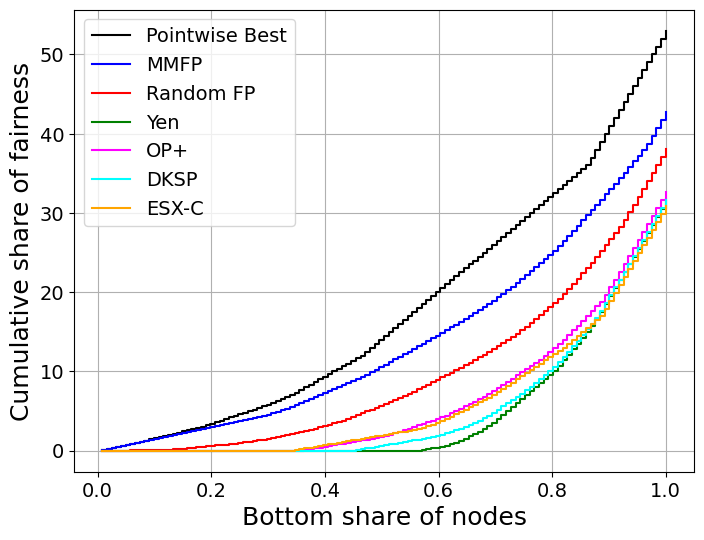

In [12]:
def plot_lorenz_curve(G, attributes=['node_flow'], legend_labels=None):
    """
    Compute and plot the Lorenz curve for the given attributes on the nodes of graph G.
    
    Parameters:
    G (networkx.DiGraph): Directed graph with node attributes.
    attributes (list): List of node attributes to compute the Lorenz curve for. Default is ['node_flow'].
    legend_labels (list or None): List of legend labels corresponding to each attribute. If None, labels are generated automatically.
    
    Returns:
    None: The function plots the Lorenz curves.
    """
    plt.figure(figsize=(8, 6))
    
    if legend_labels is None:
        legend_labels = [f'Lorenz Curve for {attr}' for attr in attributes]
    elif len(legend_labels) != len(attributes):
        raise ValueError("Number of legend labels must match the number of attributes.")
    
    # Create a new graph with nodes that have at least one non-zero attribute
    filtered_nodes = [
        (node, data) for node, data in dag.nodes(data=True)
        if any(data.get(attr, 0) != 0 for attr in attributes)
    ]
    filtered_graph = nx.DiGraph()
    filtered_graph.add_nodes_from(filtered_nodes)
    n = len(filtered_nodes)
    gini_index = ut.compute_gini_index(np.array(sim_alpha)/sim_alpha[-1])
    plt.plot(np.arange(1, n + 1) / n, np.array(sim_alpha), drawstyle='steps-post', label='Pointwise Best',color = 'black')

    
    for attribute, label in zip(attributes, legend_labels):
        # Extract the flow values from the nodes in the filtered graph
        flow_values = np.array([data[attribute] for node, data in filtered_graph.nodes(data=True)])
        
        if len(flow_values) == 0:
            raise ValueError(f"No non-zero values found for attribute '{attribute}'")
        
        # Step 1: Sort the flow values in ascending order
        sorted_flow_values = np.sort(flow_values)
        
        # Step 2: Compute the cumulative sum of the sorted flow values
        cumulative_sum = np.cumsum(sorted_flow_values)
        
        # Step 3: Normalize the cumulative sum
        #total_sum = cumulative_sum[-1]
        lorenz_curve = cumulative_sum# / total_sum
        
        # Compute the Gini index
        gini_index = ut.compute_gini_index(lorenz_curve/cumulative_sum[-1])
        
        # Add Gini index to the label
        #label_with_gini = f'{label} (Gini: {gini_index:.3f})'

        #label_with_gini = f'{label} (Gini: {gini_index:.3f})'
        
        # Plot the Lorenz curve
        n = len(lorenz_curve)
        if label == 'MMFP':
            plt.plot(np.arange(1, n + 1) / n, lorenz_curve, drawstyle='steps-post', label=label, color = 'blue')
            
        elif label == 'Random FP':
                
            plt.plot(np.arange(1, n + 1) / n, lorenz_curve, drawstyle='steps-post', label=label, color = 'red')

        elif label == 'Yen':
                
            plt.plot(np.arange(1, n + 1) / n, lorenz_curve, drawstyle='steps-post', label=label, color = 'green')
        elif label == 'OP+':
                
            plt.plot(np.arange(1, n + 1) / n, lorenz_curve, drawstyle='steps-post', label=label, color = 'magenta')

        elif label == 'DKSP':
                
            plt.plot(np.arange(1, n + 1) / n, lorenz_curve, drawstyle='steps-post', label=label, color = 'cyan')
        elif label == 'ESX-C':
                
            plt.plot(np.arange(1, n + 1) / n, lorenz_curve, drawstyle='steps-post', label=label, color = 'orange')

        else:
            plt.plot(np.arange(1, n + 1) / n, lorenz_curve, drawstyle='steps-post', label=label)
    
    #plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='Equality Line')
    

    
    plt.xlabel('Bottom share of nodes', fontsize=18)  # Larger x-axis label font size
    plt.ylabel('Cumulative share of fairness', fontsize=18)  # Larger y-axis label font size
    plt.legend(fontsize=14)  # Larger legend font size
    plt.grid(True)
    
    # Adjust xticks and yticks font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()

    
    

attributes =  ['node_flow', 'Random FP', 'yen', 'OP+ 0.8 10','DKSP','ESX-C 0.8 10']
legend_labels =  ['MMFP',   'Random FP', 'Yen', 'OP+' ,      'DKSP', 'ESX-C' ]
plot_lorenz_curve(dag, attributes=attributes, legend_labels=legend_labels)

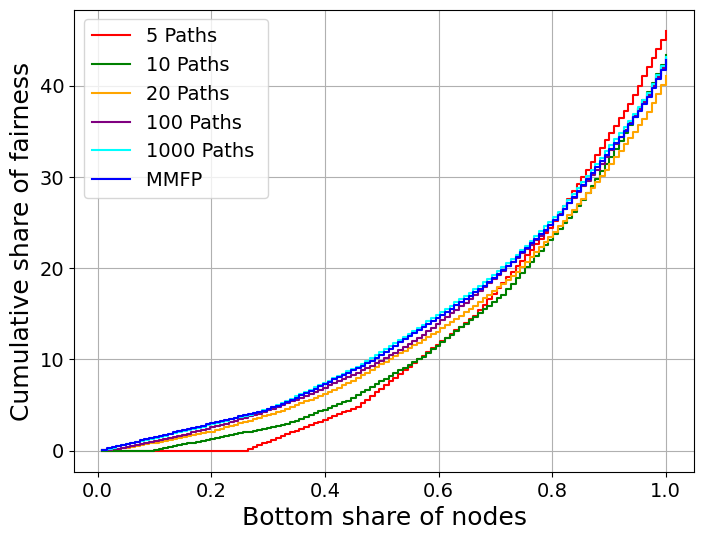

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

random.seed(1234)
ks = [5, 10, 20, 100, 1000]


for k in ks:
    paths = ut.sample_k_FP(dag, orig_node, dest_node,  k)
    ut.add_nodes_satisfaction(paths, dag, str(k))

def plot_lorenz_curve(G, attributes=['node_flow'], legend_labels=None, colors=None):
    """
    Compute and plot the Lorenz curve for the given attributes on the nodes of graph G.
    
    Parameters:
    G (networkx.DiGraph): Directed graph with node attributes.
    attributes (list): List of node attributes to compute the Lorenz curve for. Default is ['node_flow'].
    legend_labels (list or None): List of legend labels corresponding to each attribute. If None, labels are generated automatically.
    colors (list or None): List of colors for each attribute curve. If None, default colors will be used.
    
    Returns:
    None: The function plots the Lorenz curves.
    """
    plt.figure(figsize=(8, 6))
    
    if legend_labels is None:
        legend_labels = [f'Lorenz Curve for {attr}' for attr in attributes]
    elif len(legend_labels) != len(attributes):
        raise ValueError("Number of legend labels must match the number of attributes.")
        
    if colors is None:
        colors = plt.cm.tab10(range(len(attributes)))  # Use a default colormap if no colors are specified
    elif len(colors) != len(attributes):
        raise ValueError("Number of colors must match the number of attributes.")
    
    # Create a new graph with nodes that have at least one non-zero attribute
    filtered_nodes = [
        (node, data) for node, data in dag.nodes(data=True)
        if any(data.get(attr, 0) != 0 for attr in attributes)
    ]
    filtered_graph = nx.DiGraph()
    filtered_graph.add_nodes_from(filtered_nodes)
    
    for attribute, label, color in zip(attributes, legend_labels, colors):
        # Extract the flow values from the nodes in the filtered graph
        flow_values = np.array([data[attribute] for node, data in filtered_graph.nodes(data=True)])
        
        if len(flow_values) == 0:
            raise ValueError(f"No non-zero values found for attribute '{attribute}'")
        
        # Step 1: Sort the flow values in ascending order
        sorted_flow_values = np.sort(flow_values)
        
        # Step 2: Compute the cumulative sum of the sorted flow values
        cumulative_sum = np.cumsum(sorted_flow_values)
        
        # Step 3: Normalize the cumulative sum
        total_sum = cumulative_sum[-1]
        lorenz_curve = cumulative_sum / total_sum
        
        # Compute the Gini index
        gini_index = ut.compute_gini_index(lorenz_curve)
        
        # Add Gini index to the label
        if label != 'MMFP':
            label_with_gini = f'{label} Paths '
        else:
            label_with_gini = f'{label} '
        
        # Plot the Lorenz curve
        n = len(lorenz_curve)
        plt.plot(np.arange(1, n + 1) / n, cumulative_sum, drawstyle='steps-post', label=label_with_gini, color=color)

    # Plot the equality line
    #plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='Equality Line')
    
    plt.xlabel('Bottom share of nodes', fontsize=18)  # Larger x-axis label font size
    plt.ylabel('Cumulative share of fairness', fontsize=18)  # Larger y-axis label font size
    plt.legend(fontsize=14)  # Larger legend font size
    plt.grid(True)
    
    # Adjust xticks and yticks font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()

# Example usage
kstring = [str(k) for k in ks]  
attributes = kstring + ['node_flow']
legend_labels = kstring + ['MMFP']

# Define custom colors for each Lorenz curve
custom_colors = ['red', 'green', 'orange', 'purple', 'cyan', 'blue']  # Adjust colors as needed

plot_lorenz_curve(dag, attributes=attributes, legend_labels=legend_labels, colors=custom_colors)
